# Retina MNIST notebook

## import libraries

In [13]:
import os
# Set TensorFlow logging to only show errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # This silences INFO and WARNING messages
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, LayerNormalization, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
tf.get_logger().setLevel('ERROR')

try:
  import pennylane as qml
except:
  !pip install pennylane
  import pennylane as qml
from pennylane.operation import Operation

## Import the dataset

In [14]:
# !pip install medmnist

In [15]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator
import random as rd


In [16]:
def download_and_prepare_dataset(data_info: dict):
    """Utility function to download the dataset.

    Arguments:
        data_info (dict): Dataset metadata.
    """
    data_path = tf.keras.utils.get_file(origin=data_info["url"], md5_hash=data_info["MD5"])

    with np.load(data_path) as data:
        # Get videos
        train_videos = data["train_images"]
        valid_videos = data["val_images"]
        test_videos = data["test_images"]

        # Get labels
        train_labels = data["train_labels"].flatten()
        valid_labels = data["val_labels"].flatten()
        test_labels = data["test_labels"].flatten()

    return (
        (train_videos, train_labels),
        (valid_videos, valid_labels),
        (test_videos, test_labels),
    )


# Get the metadata of the dataset
info = medmnist.INFO["retinamnist"]
# info = medmnist.INFO["retinamnist"]


# Get the dataset
prepared_dataset = download_and_prepare_dataset(info)
(x_train, y_train) = prepared_dataset[0]
(x_val, y_val) = prepared_dataset[1]
(x_test, y_test) = prepared_dataset[2]

In [17]:
import numpy as np
from sklearn.decomposition import PCA
from tensorflow.keras.utils import to_categorical
x_train = x_train/255
x_test = x_test/255

# Expand the dimensions of the images to (28, 28, 1) to represent the grayscale channel explicitly
train_images = np.expand_dims(x_train, -1)
test_images = np.expand_dims(x_test, -1)

# Flatten the images to 2D arrays for PCA
train_images_flat = train_images.reshape(train_images.shape[0], -1)  # Shape: (num_samples, 28*28)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

# Initialize PCA to keep 8 components
pca = PCA(n_components=6)

# Fit PCA on the training images and transform the datasets
train_images = pca.fit_transform(train_images_flat)
test_images = pca.transform(test_images_flat)

# Map the labels 3 -> 0 and 6 -> 1
y_train = np.where(y_train == 0, 0, 1)
y_test = np.where(y_test == 0, 0, 1)

# One-hot encode the labels
train_labels = to_categorical(y_train, 2)
test_labels = to_categorical(y_test, 2)

# Print the shapes of the processed datasets
print("Shape of train images after PCA:", train_labels.shape)
print("Shape of test images after PCA:", test_labels.shape)
print("Shape of train labels:", train_labels.shape)
print("Shape of test labels:", test_labels.shape)


Shape of train images after PCA: (1080, 2)
Shape of test images after PCA: (400, 2)
Shape of train labels: (1080, 2)
Shape of test labels: (400, 2)


In [18]:
unique_labels = np.unique(y_train)
print(f"Unique labels in the training set: {unique_labels}")

Unique labels in the training set: [0 1]


In [19]:
def plot_images(images, labels, num_images=25, figsize=(10,10)):
    grid_size = 5
    plt.figure(figsize=figsize)

    for i in range(num_images):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap='gray')
        plt.xlabel(f'Label: {labels[i]}')
    plt.show()

In [20]:
def plot_learning_curve(history):
    # Extracting training and validation accuracy
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Extracting training and validation loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plotting the accuracy
    plt.figure(figsize=(12, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()


## Common Quantum functions

In [21]:
class RBSGate(Operation):
    num_params = 1
    num_wires = 2
    par_domain = 'R'

    def __init__(self, theta, wires):
        super().__init__(theta, wires=wires)
        self.theta = theta

    @staticmethod
    def compute_matrix(theta):
        cos = tf.cos(theta)
        sin = tf.sin(theta)
        return tf.convert_to_tensor([
            [1, 0, 0, 0],
            [0, cos, sin, 0],
            [0, -sin, cos, 0],
            [0, 0, 0, 1]
        ], dtype=tf.float64)

    def adjoint(self):
        return RBSGate(-self.parameters[0], wires=self.wires)

    def label(self, decimals=None, base_label=None, **kwargs):
        theta = self.parameters[0]
        return f"RBS({theta:.2f})"
def convert_array(X):
    alphas = tf.zeros(X.shape[:-1] + (X.shape[-1]-1,), dtype=X.dtype)
    X_normd = tf.linalg.l2_normalize(X, axis=-1)
    for i in range(X.shape[-1]-1):
        prod_sin_alphas = tf.reduce_prod(tf.sin(alphas[..., :i]), axis=-1)
        updated_value = tf.acos(X_normd[..., i] / prod_sin_alphas)
        indices = tf.constant([[i]])
        updates = tf.reshape(updated_value, [1])
        alphas = tf.tensor_scatter_nd_update(alphas, indices, updates)
    return alphas
def vector_loader(alphas, wires=None, is_x=True, is_conjugate=False):
    if wires is None:
        wires = list(range(len(alphas) + 1))
    if is_x and not is_conjugate:
        qml.PauliX(wires=wires[0])
    if is_conjugate:
        for i in range(len(wires) - 2, -1, -1):
            qml.apply(RBSGate(-alphas[i], wires=[wires[i], wires[i+1]]))
    else:
        for i in range(len(wires) - 1):
            qml.apply(RBSGate(alphas[i], wires=[wires[i], wires[i+1]]))
    if is_x and is_conjugate:
        qml.PauliX(wires=wires[0])
def pyramid_circuit(parameters, wires=None):
    if wires is None:
        length = len(qml.device.wires)
    else:
        length = len(wires)

    k = 0

    for i in range(2 * length - 2):
        j = length - abs(length - 1 - i)

        if i % 2:
            for _ in range(j):
                if _ % 2 == 0 and k < (parameters.shape[0]):
                    qml.apply(RBSGate(parameters[k], wires=([wires[_], wires[_ + 1]])))
                    k += 1
        else:
            for _ in range(j):
                if _ % 2 and k < (parameters.shape[0]):
                    qml.apply(RBSGate(parameters[k], wires=([wires[_], wires[_ + 1]])))
                    k += 1

# qOrthNN + Gradient Pruning

In [22]:
import math

# Define a step counter
global_step = tf.Variable(0, dtype=tf.int64, trainable=False)

# Define a custom callback
class StepCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        global_step.assign(0)
    def on_train_batch_end(self, batch, logs=None):
        global_step.assign_add(1)
        current_step = global_step.numpy()
        if current_step % 5 == 0:
            # Increase the pruning ratio
            current_prune_ratio = self.model.prune_ratio
            # Increase prune_ratio by multiplying with exp(0.1)
            new_prune_ratio = min(current_prune_ratio * math.exp(0.1), 1.0)  # Cap at 1.0
            self.model.prune_ratio = new_prune_ratio
    # def on_epoch_begin(self, epoch, logs=None):
    #     tf.print("Updated prune_ratio to", self.model.prune_ratio)

In [23]:
class HybridModel(tf.keras.Model):
    def __init__(self,random1):
        super(HybridModel, self).__init__()
        
        rd.seed(random1)
        np.random.seed(random1)
        tf.random.set_seed(random1)
        qml.numpy.random.seed(random1)
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(6, activation='linear', dtype=tf.float64)
        self.quantum_weights = self.add_weight(
            shape=(15,),
            initializer="zeros",
            trainable=True,
            dtype=tf.float32
        )
        self.dev = qml.device('default.qubit.tf', wires=6)
        # Pruning attributes
        self.accumulated_grads = tf.Variable(tf.zeros_like(self.quantum_weights), trainable=False)
        self.accumulate_flag = tf.Variable(True, trainable=False)
        
        self.accumulate_window = tf.constant(10)
        self.prune_window = tf.constant(8)
        self.prune_ratio = tf.constant(0.8)
        
        self.accumulate_count = tf.Variable(6, dtype=tf.int32, trainable=False)
        self.prune_count = tf.Variable(6, dtype=tf.int32, trainable=False)


        @qml.qnode(self.dev, interface='tf', diff_method='backprop')
        def quantum_circuit(inputs, weights):
            inputs = tf.cast(inputs, tf.float32)
            weights = tf.cast(weights, tf.float32)
            vector_loader(convert_array(inputs), wires=range(6))
            pyramid_circuit(weights, wires=range(6))
            return [qml.expval(qml.PauliZ(wire)) for wire in range(6)]

        self.quantum_circuit = quantum_circuit
        self.classical_nn_2 = tf.keras.layers.Dense(2, activation='sigmoid', dtype=tf.float64)

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float64)
        flattened_inputs = self.flatten(inputs)
        classical_output = self.dense(flattened_inputs)
        quantum_outputs = tf.map_fn(
            lambda x: tf.stack(self.quantum_circuit(x, self.quantum_weights)),
            classical_output,
            fn_output_signature=tf.TensorSpec(shape=(6,), dtype=tf.float64)
        )
        # Handle NaN values in quantum outputs
        quantum_outputs = tf.where(tf.math.is_nan(quantum_outputs), tf.zeros_like(quantum_outputs), quantum_outputs)

        # Combine and process quantum outputs through additional NN layers
        quantum_outputs = tf.reshape(quantum_outputs, [-1, 6])
        nn_output = self.classical_nn_2(quantum_outputs)

        return nn_output
    
    @tf.function
    def train_step(self, data):
        x, y = data  # Unpack the data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        # Index of quantum_weights in trainable_variables
        quantum_weights_idx = 0
        
        # switch flag for PGP
        @tf.function
        def switch_flag():
            if self.accumulate_count == 0:
                self.accumulate_count.assign(self.accumulate_window)
                self.accumulate_flag.assign(False)
            elif self.prune_count == 0:
                self.prune_count.assign(self.prune_window)
                self.accumulate_flag.assign(True)
        switch_flag()
        
        # Probabilistic Gradient Pruning
        if tf.equal(self.accumulate_flag, True):
            # Step 1: Accumulate gradients for quantum_weights
            # tf.print("Accu phase:", self.accumulate_count)
            self.accumulate_count.assign_sub(1)
            if gradients[quantum_weights_idx] is not None:
                self.accumulated_grads.assign_add(gradients[quantum_weights_idx])

            # Apply gradients for other variables (excluding quantum_weights)
            # other_gradients = []
            # other_variables = []
            # for i, (grad, var) in enumerate(zip(gradients, self.trainable_variables)):
            #     if i != quantum_weights_idx and grad is not None:
            #         other_gradients.append(grad)
            #         other_variables.append(var)
            self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        else:
            # Step 2: Prune weights of quantum_weights
            # tf.print("Pruning phase:",self.prune_count)
            self.prune_count.assign_sub(1)
            # Normalize the accumulated gradients
            grad_min = tf.reduce_min(self.accumulated_grads)
            grad_max = tf.reduce_max(self.accumulated_grads)
            epsilon = 1e-8
            norm_grads = (self.accumulated_grads - grad_min) / (grad_max - grad_min + epsilon)

            # Add epsilon to norm_grads to avoid log(0)
            norm_grads_with_epsilon = norm_grads + epsilon

            # Compute logits for categorical sampling
            logits = tf.math.log(norm_grads_with_epsilon)

            # Determine the number of parameters to sample
            num_params = self.quantum_weights.shape[0]
            num_samples = int(self.prune_ratio * num_params)
            num_samples = tf.maximum(1, num_samples) # Ensure at least one parameter is sampled

            # Sample indices based on the normalized gradients
            indices = tf.random.categorical([logits], num_samples=num_samples)
            indices = tf.clip_by_value(indices, 0, self.quantum_weights.shape[0] - 1)  # Ensure indices are within range

            # Create a boolean mask to select the parameters to keep
            mask = tf.zeros_like(self.quantum_weights, dtype=tf.bool)
            indices = tf.cast(indices, tf.int32)
            indices = tf.reshape(indices, [-1, 1])  # Ensure indices are shaped correctly
            updates = tf.ones([tf.shape(indices)[0]], dtype=tf.bool)  # Create updates matching the indices length

            mask = tf.tensor_scatter_nd_update(mask, indices, updates)

            # Apply the mask to the accumulated gradients
            pruned_grad = tf.where(mask, self.accumulated_grads[0], tf.zeros_like(self.accumulated_grads[0]))

            # Apply the pruned gradient to quantum_weights
            self.optimizer.apply_gradients([(pruned_grad, self.quantum_weights)])

            # Apply gradients for other variables (excluding quantum_weights)
            other_gradients = []
            other_variables = []
            for i, (grad, var) in enumerate(zip(gradients, self.trainable_variables)):
                if i != quantum_weights_idx and grad is not None:
                    other_gradients.append(grad)
                    other_variables.append(var)
            self.optimizer.apply_gradients(zip(other_gradients, other_variables))

            # Reset accumulator and accumulate window
            self.accumulated_grads.assign(tf.zeros_like(self.accumulated_grads))

        # Sanitize weights: replace NaNs with zeros
        for var in self.trainable_variables:
            # Create a mask where NaNs are present
            nan_mask = tf.math.is_nan(var)
            # Replace NaNs with zeros
            sanitized_var = tf.where(nan_mask, tf.zeros_like(var), var)
            # Assign the sanitized variable back to the model
            var.assign(sanitized_var)

        # Update metrics
        self.compiled_metrics.update_state(y, y_pred)
        # tf.print(self.quantum_weights)
        # Return a dictionary of metric results
        return {m.name: m.result() for m in self.metrics}

## Monte Carlo inspection

In [24]:
# Define model and optimizer
for random in range(10,100,10):
    rd.seed(random)
    np.random.seed(random)
    tf.random.set_seed(random)
    qml.numpy.random.seed(random)
    model = HybridModel(random)
    total_steps = 16  # Example value; adjust based on your training setup

    # Cosine learning rate scheduler from 0.3 to 0.03
    initial_learning_rate = 0.3
    final_learning_rate = 0.03
    alpha = final_learning_rate / initial_learning_rate

    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=total_steps,
        alpha=alpha
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    # Compile the model
    model.compile(optimizer=optimizer, 
                loss='binary_crossentropy', 
                metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

    # Number of Monte Carlo simulations
    n_simulations = 10

    # Container for results
    accuracies = []
    aucs = []

    # Monte Carlo Resampling
    for _ in range(n_simulations):

        
        X_train, y_train = train_images, train_labels
        X_test, y_test = test_images, test_labels

        # Train the model on resampled data
        model.fit(X_train, y_train, 
                epochs=5,  # Fewer epochs for faster resampling
                batch_size=6, 
                verbose=0)  # Suppress verbose output
        
        # Evaluate the model on the test set
        test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test, verbose=0)
        
        # Store the accuracy and AUC
        accuracies.append(test_accuracy)
        aucs.append(test_auc)

    # Calculate average metrics and 95% confidence intervals
    mean_accuracy = np.mean(accuracies)
    ci_accuracy_lower = np.percentile(accuracies, 2.5)
    ci_accuracy_upper = np.percentile(accuracies, 97.5)

    mean_auc = np.mean(aucs)
    ci_auc_lower = np.percentile(aucs, 2.5)
    ci_auc_upper = np.percentile(aucs, 97.5)

    # Print results
    print(f"Estimated Accuracy: {mean_accuracy:.4f}")
    print(f"95% Confidence Interval for Accuracy: [{ci_accuracy_lower:.4f}, {ci_accuracy_upper:.4f}]")
    print(f"Estimated AUC: {mean_auc:.4f}")
    print(f"95% Confidence Interval for AUC: [{ci_auc_lower:.4f}, {ci_auc_upper:.4f}]")


Estimated Accuracy: 0.5650
95% Confidence Interval for Accuracy: [0.5650, 0.5650]
Estimated AUC: 0.5650
95% Confidence Interval for AUC: [0.5650, 0.5650]
Estimated Accuracy: 0.4610
95% Confidence Interval for Accuracy: [0.4350, 0.6365]
Estimated AUC: 0.4646
95% Confidence Interval for AUC: [0.4350, 0.6642]
Estimated Accuracy: 0.5665
95% Confidence Interval for Accuracy: [0.4350, 0.7190]
Estimated AUC: 0.5763
95% Confidence Interval for AUC: [0.4350, 0.7583]
Estimated Accuracy: 0.5705
95% Confidence Interval for Accuracy: [0.5650, 0.6076]
Estimated AUC: 0.5769
95% Confidence Interval for AUC: [0.5650, 0.6571]
Estimated Accuracy: 0.5650
95% Confidence Interval for Accuracy: [0.5650, 0.5650]
Estimated AUC: 0.5650
95% Confidence Interval for AUC: [0.5650, 0.5650]
Estimated Accuracy: 0.5813
95% Confidence Interval for Accuracy: [0.5650, 0.6909]
Estimated AUC: 0.5847
95% Confidence Interval for AUC: [0.5650, 0.7179]
Estimated Accuracy: 0.5650
95% Confidence Interval for Accuracy: [0.5650, 0.

# Plot the training and validation loss

Training with random seed: 20
Epoch 1/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 35s 16ms/step - accuracy: 0.5901 - auc: 0.6119 - loss: 0.5072 - val_accuracy: 0.4350 - val_auc: 0.4350 - val_loss: 0.6954
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5388 - auc: 0.5355 - loss: 0.4993 - val_accuracy: 0.4350 - val_auc: 0.4350 - val_loss: 0.7124
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.5359 - auc: 0.5361 - loss: 0.5006 - val_accuracy: 0.4350 - val_auc: 0.4350 - val_loss: 0.7074
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5400 - auc: 0.5328 - loss: 0.4997 - val_accuracy: 0.4350 - val_auc: 0.4350 - val_loss: 0.7121
Testing Process
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4695 - auc: 0.4695 - loss: 0.6943
Test Loss: 0.695360004901886
Test Accuracy: 0.4350000023841858
Test AUC: 0.4349999725818634


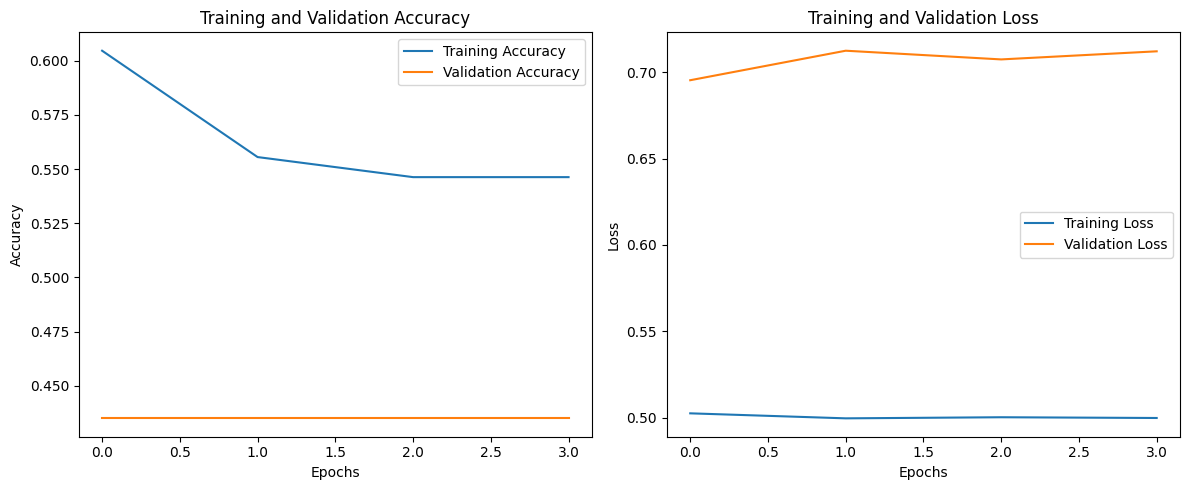

In [25]:
accuracy = []
auc = []
random = 20
rd.seed(random)
np.random.seed(random)
tf.random.set_seed(random)
qml.numpy.random.seed(random)
print('Training with random seed:', random)
model = HybridModel(random)
total_steps = 16  # Example value; adjust based on your training setup

# Cosine learning rate scheduler from 0.3 to 0.03
initial_learning_rate = 0.3
final_learning_rate = 0.03
alpha = final_learning_rate / initial_learning_rate

# lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
#     initial_learning_rate=initial_learning_rate,
#     decay_steps=total_steps,
#     alpha=alpha
# )
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',   # Metric to monitor
#     patience=3,           # Number of epochs with no improvement after which training will be stopped
#     min_delta=0.01,      # Minimum change to qualify as an improvement
#     restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
# )
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy','auc'])

# Train the model and store the validation accuracy
history = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=2,
    validation_data=(test_images, test_labels),
    verbose=1,
    callbacks=[early_stopping, StepCallback()]  # Include the EarlyStopping callback
)

print('Testing Process')
test_loss, test_accuracy , test_auc = model.evaluate(test_images, test_labels)
accuracy.append(test_accuracy)
auc.append(test_auc)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")

plot_learning_curve(history)
